<a href="https://colab.research.google.com/github/SSInimgba/Computer_Vision/blob/master/Rice_or_NotRice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We have gathered a dataset of rice dishes from google images. Manually inspecting the dataset showed that there are images included that are not food. So to improve the quality of the dataset, we will create a binary classifier that helps us filter non-food images from our dataset.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Import the necessary libraries

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
import torchvision.datasets as dset
from torchvision import transforms
import matplotlib.pyplot as plt


## Organizing the data into subfolders using shell commands

In [0]:
!unzip  -q "/content/drive/My Drive/Colab Notebooks/Nigerian_Food_Project/Food-5K.zip"

In [0]:
!unzip -q "/content/drive/My Drive/Colab Notebooks/Nigerian_Food_Project/images.zip"

In [0]:
%cd /content/Food-5K

/content/Food-5K


In [0]:
cd /content/Food-5K/evaluation

/content/Food-5K/evaluation


In [0]:
mv * 1

mv: cannot move '1' to a subdirectory of itself, '1/1'


## Reading in the data

In [0]:

#Transform Image
transformations = transforms.Compose([
                            transforms.RandomRotation(30),
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.ToTensor(),
                            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [0]:
train_data = dset.ImageFolder('/content/Food-5K/training', transform = transformations)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_data = dset.ImageFolder('/content/Food-5K/validation', transform = transformations)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)
eval_data = dset.ImageFolder('/content/Food-5K/evaluation', transform = transformations)
eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=32, shuffle=True)

In [0]:
#Image Labels
classes = train_data.classes
classes

['0', '1']

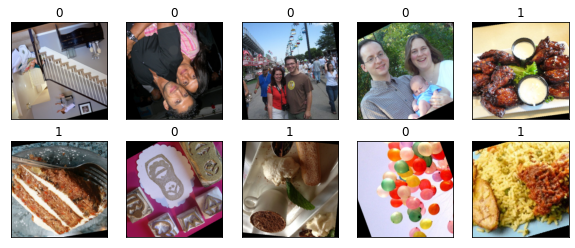

In [0]:
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))

# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])



```
# This is formatted as code
```

##Create CNN to train on our data

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    #Convolutional layer
    self.conv1 = nn.Conv2d(3,16,5)

    #Max Pooling layer
    self.pool = nn.MaxPool2d(2,2)

    #Second convolutional layer
    self.conv2 = nn.Conv2d(16,32,5)

    #Dropout Layer
    self.dropout = nn.Dropout(0.2)

    #Fully Connected Layers
    self.fc1 = nn.Linear(32*53*53, 256)
    self.fc2 = nn.Linear(256,84)
    self.fc3 = nn.Linear(84,2)
    self.softmax = nn.LogSoftmax(dim = 1)



  def forward(self,x):
    #add sequence of convolutional and max pooling layers
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = x.view(-1,32*53*53)
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.softmax(self.fc3(x))
    return x

In [0]:
#Create a CNN
train_on_gpu = torch.cuda.is_available()
model = Net()

if train_on_gpu:
  model = model.cuda()

In [0]:
model

In [0]:
#Loss Funtion
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [0]:
# number of epochs to train the model
n_epochs = 10
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in val_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_data)
    valid_loss = valid_loss/len(val_data)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_food.pt')
        valid_loss_min = valid_loss

#Model with a pretrained data

In [0]:
import torchvision.models as models

In [0]:
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    # Replace the last fully-connected layer
     # Parameters of newly constructed modules have requires_grad=True by default

features = model.fc.in_features
model.fc = nn.Linear(features,2)


train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  model = model.cuda()



In [0]:
#Loss Funtion
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [0]:
#Transform Image
transformations = transforms.Compose([
                            transforms.RandomRotation(30),
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                        std=[0.229, 0.224, 0.225])
])

test_transformations = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                        std=[0.229, 0.224, 0.225])
])

train_data = dset.ImageFolder('/content/Food-5K/training', transform = transformations)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_data = dset.ImageFolder('/content/Food-5K/validation', transform = transformations)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)
eval_data = dset.ImageFolder('/content/Food-5K/evaluation', transform = test_transformations)
eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=32, shuffle=True)

In [0]:
# number of epochs to train the model
n_epochs = 10
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():

      for data, target in val_loader:
          # move tensors to GPU if CUDA is available
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          # update average validation loss 
          valid_loss += loss.item()*data.size(0)
      
      # calculate average losses
      train_loss = train_loss/len(train_data)
      valid_loss = valid_loss/len(val_data)
          
      # print training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model_food_2.pt')
          valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.263312 	Validation Loss: 0.111367
Validation loss decreased (inf --> 0.111367).  Saving model ...
Epoch: 2 	Training Loss: 0.121426 	Validation Loss: 0.088277
Validation loss decreased (0.111367 --> 0.088277).  Saving model ...
Epoch: 3 	Training Loss: 0.107972 	Validation Loss: 0.076591
Validation loss decreased (0.088277 --> 0.076591).  Saving model ...
Epoch: 4 	Training Loss: 0.102798 	Validation Loss: 0.084880
Epoch: 5 	Training Loss: 0.095911 	Validation Loss: 0.073559
Validation loss decreased (0.076591 --> 0.073559).  Saving model ...
Epoch: 6 	Training Loss: 0.092114 	Validation Loss: 0.096538
Epoch: 7 	Training Loss: 0.089049 	Validation Loss: 0.071693
Validation loss decreased (0.073559 --> 0.071693).  Saving model ...
Epoch: 8 	Training Loss: 0.088088 	Validation Loss: 0.068405
Validation loss decreased (0.071693 --> 0.068405).  Saving model ...
Epoch: 9 	Training Loss: 0.084540 	Validation Loss: 0.069430
Epoch: 10 	Training Loss: 0.093481 	Valida

In [0]:
"""x, y = torch.max(output,1)
print(f'this is x: {x}')
print(f'this is y: {y}')"""

"x, y = torch.max(output,1)\nprint(f'this is x: {x}')\nprint(f'this is y: {y}')"

In [0]:
# track test loss
test_loss = 0.0
batch_size = 32
class_correct = list(0. for i in range(2)) #[0.0, 0.0]
class_incorrect = list(0. for i in range(2)) #[0.0, 0.0]
class_total = list(0. for i in range(2)) #[0.0, 0.0]





model.eval()#
i=1
# iterate over test data
len(val_loader) #39

for data, target in val_loader:
    i=i+1
    if len(target)!= batch_size:
        continue
        
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # calculate the batch loss
    loss = criterion(output, target)

    # update test loss 
    test_loss += loss.item()*data.size(0)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1) #_ is a tensor, pred is the label

    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred)) #tensor of boolean result comparing the prediction to the actual labels
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy()) #returns array in reduced dimension
    # calculate test accuracy for each object class

    
    for i in range(batch_size):       
        label = target.data[i] #gets a label at a particular index
        class_correct[label] += correct[i].item() #adds a count to the label[0,1] if correct[i].item() is True.
        class_incorrect[label] += (correct[i].item()) == 0 #adds a count to the label[0,1] if correct[i].item() is False.
        class_total[label] += 1 #culminates total for each label eg [0:20,1:40]
  

# average test loss
test_loss = test_loss/len(val_data)
print(f'Test Loss: {test_loss}\n')

for i in range(2):
    if class_total[i] > 0:
        print(f'Test Accuracy of {classes[i]}: {100* class_correct[i]//class_total[i]}% ({np.sum(class_correct[i])}/{np.sum(class_total[i])})')
        print(f'Test Inaccuracy of {classes[i]}: {100* class_incorrect[i]//class_total[i]}% ({np.sum(class_incorrect[i])}/{np.sum(class_total[i])})')
        print('\n')  
    else:
        print(f'Test Accuracy of {classes[i]}: N/A (no training examples)')

print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) // np.sum(class_total)}% ({np.sum(class_correct)}/{np.sum(class_total)})') 
print(f'Test Inaccuracy (Overall): {100. * np.sum(class_incorrect) // np.sum(class_total)}% ({np.sum(class_incorrect)}/{np.sum(class_total)})') 

Test Loss: 0.07241078680772997

Test Accuracy of 0: 97.0% (482.0/494.0)
Test Inaccuracy of 0: 2.0% (12.0/494.0)


Test Accuracy of 1: 96.0% (700.0/722.0)
Test Inaccuracy of 1: 3.0% (22.0/722.0)



Test Accuracy (Overall): 97.0% (1182.0/1216.0)
Test Inaccuracy (Overall): 2.0% (34.0/1216.0)


In [0]:

test = torch.utils.data.DataLoader(val_data, batch_size=len(val_data), shuffle=True)

model.eval()
for i, (data,target) in enumerate(test):
  if train_on_gpu:
    data , target = data.cuda(), target.cuda()
  output = model(data)
  _, pred = torch.max(output,1)
  pred = np.squeeze(pred.numpy())
  probs = [F.softmax(el, dim=0)[i].item() for i, el in zip(pred, output)]
 

  

In [0]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [0]:
pred, probs 

NameError: ignored

In [0]:
probs

[0.999526858329773,
 0.9984366297721863,
 0.9986961483955383,
 0.9978758096694946,
 0.9757580757141113,
 0.9998854398727417,
 0.9906243681907654,
 0.9979887008666992,
 0.9977446794509888,
 0.998829185962677,
 0.9994291663169861,
 0.9995263814926147,
 0.9898228645324707,
 0.9983521699905396,
 0.99806147813797,
 0.9190441966056824,
 0.5665929317474365,
 0.9999562501907349,
 0.9640324115753174,
 0.9764812588691711]

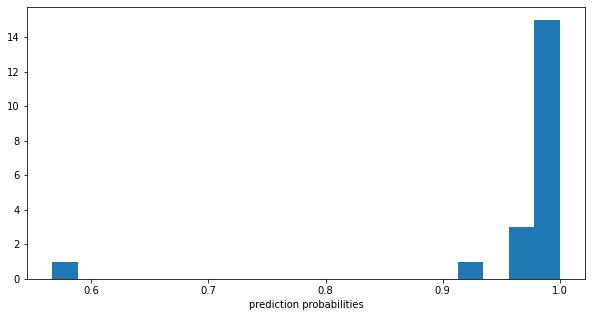

In [0]:
fig = plt.figure(figsize=(10, 5))
plt.xlabel('prediction probabilities')
plt.hist(probs, label = 'prediction probabalities', bins = 20);

IndexError: ignored

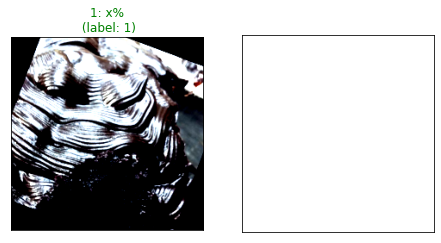

In [0]:
fig = plt.figure(figsize=(20, 8))

# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    #std = np.array([0.229, 0.224, 0.225])
    #mean = np.array([0.485, 0.456, 0.406])
    img = incorrect_examples[idx][idx]
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    imshow(img)
    ax.set_title(f"{classes[pred[idx]]}: x%\n (label: {classes[target[idx]]})", 
        color=("green" if pred[idx]==target[idx].item() else "red"))

In [0]:
"""for i in range(32):
   print(correct[i].item())"""

"""class_incorrect = [0.0, 0.0]

for i in range(20):       
        label = target.data[i] #gets a label at a particular index eg 0 at index 1 or 0 at index 2 or 1 at index 5
        class_correct[label] += correct[i].item() #adds a count to the label[0,1] if correct[i].item() is True only.
        class_incorrect[label] += (correct[i].item()) == False
        class_total[label] += 1
print(class_correct)
print(class_incorrect)
print(class_total)"""



**a.view(x,y)**: reshapes a tensor, where x is the row and y is the column. When x is "-1" it means that you dont know how many rows will be returned but you know the number of columns. It is similar to the numpy reshape function.

**a.view_as(x)**: reshapes a tensor to the shape of tensor x.

**a.randn(x,y)**:creates a tensor of shape row x and column y filled with random numbers from a normal distribution with mean 0 and variance 1. 

**a.size**: returns the shape of the tensor.

**a.max()**: returns the max value in the tensor.

**a.min()**: returns the min value in the tensor.

**a.equal(m,n)**: returns a boolean value after comparing m and n shapes.

**a.eq(m,n)**: returns a boolean value after comparing all elemenst in m and n.

**pred.eq(target.data.view_as(pred))** : get the data of target and reshaped it to pred and return the boolean values if the results match pred.

**len(val_loader)** : is the number of data in the datasets divided by the batches. 

In [0]:
def conf_matrix(data, target):
  n_classes = 2
  confusion_matrix = torch.zeros(n_classes, n_classes)

  with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
  
  #print(f'this is the confusion matrix at the start: {confusion_matrix}')
      for t,p in zip(target.view(-1), pred.view(-1)):
        confusion_matrix[t.long(),p.long()] +=1
  print(confusion_matrix.diag()/confusion_matrix.sum(1))
  return(print(confusion_matrix))

In [0]:
conf_matrix(data,target)

In [0]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))


In [0]:
 #confusion 
n_classes = 2

confusion_matrix = torch.zeros(n_classes, n_classes)

with torch.no_grad():
  for i, (inputs, classes) in enumerate(val_loader):
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
        
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1




RuntimeError: ignored